In [1]:
import os
import autoreload
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import local_utils
import flopy
from simulationFFT import *

from SimPEG import Mesh, Maps, Utils, EM

from simpegEM1D import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, get_vertical_discretization_time, 
    EM1DSurveyTD,skytem_HM_2015
)
#Imports from simpegskytem notebook SLO-simulation
from scipy.constants import mu_0
from pymatsolver import PardisoSolver
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from simpegskytem import ProblemSkyTEM, GlobalAEMSurveyTD, GlobalSkyTEM, get_skytem_survey
from scipy.interpolate import NearestNDInterpolator

datadir = Path('../data/synthetic_test')
figdir = datadir

flopy is installed in /Users/sgkang/anaconda3/lib/python3.7/site-packages/flopy


In [2]:
ucnobj = flopy.utils.binaryfile.UcnFile(datadir.joinpath('concentration_binary.UCN'))
times = ucnobj.get_times()
print('Available times (days):\n{}'.format(times))

time1 = 1.0
time2 = 900.0 # 2.5 years later (this is the case for the 2017 vs 2019 AEM data collection)
time3 = 7200.0 # 20 years later

conc_mat1 = ucnobj.get_data(totim=time1)
conc_mat2 = ucnobj.get_data(totim=time2)
conc_mat3 = ucnobj.get_data(totim=time3)

times = (time1,time2,time3)
conc_mats = (conc_mat1,conc_mat2,conc_mat3)

Available times (days):
[1.0, 180.0, 360.0, 540.0, 720.0, 759.0, 900.0, 1080.0, 1260.0, 1440.0, 1517.0, 1620.0, 1800.0, 1980.0, 2160.0, 2275.0, 2340.0, 2520.0, 2700.0, 2880.0, 3032.0, 3060.0, 3240.0, 3420.0, 3600.0, 3780.0, 3790.0, 3960.0, 4140.0, 4320.0, 4500.0, 4548.0, 4680.0, 4860.0, 5040.0, 5220.0, 5306.0, 5400.0, 5580.0, 5760.0, 5940.0, 6064.0, 6120.0, 6300.0, 6480.0, 6660.0, 6822.0, 6840.0, 7020.0, 7200.0, 7380.0, 7560.0, 7579.0, 7740.0, 7920.0, 8100.0, 8280.0, 8337.0, 8460.0, 8640.0, 8820.0, 9000.0, 9095.0, 9180.0, 9360.0, 9540.0, 9720.0, 9853.0, 9900.0, 10080.0, 10260.0, 10440.0, 10611.0, 10620.0, 10800.0, 10980.0, 11160.0, 11340.0, 11369.0, 11520.0, 11700.0, 11880.0, 12060.0, 12126.0, 12240.0, 12420.0, 12600.0, 12780.0, 12884.0, 12960.0, 13140.0, 13320.0, 13500.0, 13642.0, 13680.0, 13860.0, 14040.0, 14220.0, 14400.0]


In [3]:
#RP transforms 

def WS_sigma(sigma_f, por = 0.4, CEC=1,B0=4.5e-8, m=1.3):
    rho_grain = 2650*1000 #g/m^3
#     CEC = 1 #meq/g    1:smect,  .2:Ill,  .02-.09:Kaol
#     B0 = 4.78e-8  #m^2/(sV)
    F = por**(-m)
    Qv = rho_grain*((1-por)/por)*CEC
    B = B0*(1-.6*np.exp(-sigma_f/.013))
    sigma_b = 1/F*(sigma_f + B*Qv)
    return sigma_b,B,Qv


def HSU(conc_mat,CF_mat,mTDS=1.4200556641030946,bTDS=332.7093594248108,**kwargs):
    #kwargs fed to WS_sigma
    Cw = (mTDS*conc_mat*1000 + bTDS)/1e4
    sig_bs = WS_sigma(Cw,CEC=0,**kwargs)[0]
    sig_bc = WS_sigma(Cw,CEC=1,**kwargs)[0]
    return sig_bc*(1 - (3*(1-CF_mat)*(sig_bc-sig_bs))/(3*sig_bc - CF_mat*(sig_bc-sig_bs)))

### 1) Rock-physics
#### Model: Use W-S to calculate end members (Clay,Sand) and Hashin-Strickman upper bound to upscale





### W-S
$\large \sigma_b = \frac{1}{F} (\sigma_{f} + B*Q_{v})$
$F$ = Formation factor = $\phi^{-m}$
<br>
$\phi$ = Porosity
<br>
$m$ = Cementation exponent
<br>
$\sigma_f$ = Fluid conductivity
<br>
$B$ = 
<br>
$Q_v$ = 
<br><br>

### HS+

<img src='HSU.png' alt="Drawing" style="width: 300px;" align="Left"/>
<br><br><br><br>


$\chi$ = Volume fraction 
<br>
$\sigma$ = Conductivity
<br>


In [4]:
#Re-creating the random field used in the simulation

nlay,nrow,ncol = (26, 20, 100)
delv,delc,delr = (3., 30., 30.)
varlist = local_utils.load_obj(datadir,'varlist_final')


it = 1
CF_glob = varlist['CF_glob'][it]
CF_var = varlist['CF_var'][it]
corr_len = varlist['corr_len'][it]
corr_len_yx = varlist['corr_len_yx'][it]
corr_len_zx = varlist['corr_len_zx'][it]
vario_type = varlist['vario_type'][it]
lcol = int(corr_len/delr)
llay = int(corr_len*corr_len_zx/np.mean(delv))
lrow = int(corr_len*corr_len_yx/delc)
seed = varlist['seed'][it]
por_mean = varlist['por_mean'][it]
por_var  = varlist['por_var'][it]



cf_mat = simulFFT(nrow,nlay, ncol,
                 CF_glob,
                 CF_var,
                 vario_type,
                 lrow , llay, lcol,seed=seed)
cf_mat[cf_mat > 1.] = 1.
cf_mat[cf_mat < 0.] = 0.

por_mat = simulFFT(nrow,nlay, ncol,
                 por_mean,
                 por_var,
                 vario_type,
                 lrow , llay, lcol,seed=seed)
por_mat[por_mat > 1.] = 1.
por_mat[por_mat < 0.] = 0.



mTDS=1.4200556641030946
bTDS=332.7093594248108
Cw = (mTDS*conc_mats[0]*1000 + bTDS)/1e4
bulk = WS_sigma(Cw,por=por_mat)[0]


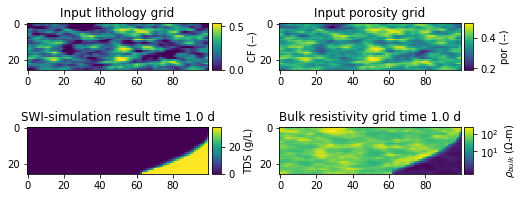

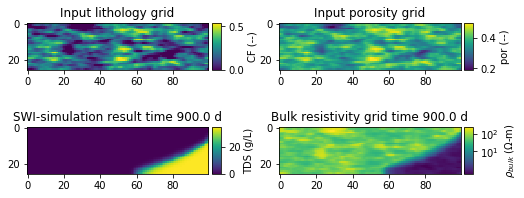

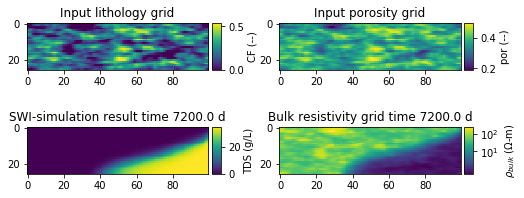

In [5]:
#Plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable

rowslice = 5
saveyn=False
sig_mats = []
for tim,cmat in zip(times,conc_mats):
    sig_mats.append(HSU(cmat,cf_mat,por=por_mat))
    
    f,axs=  plt.subplots(2,2,figsize=(8,3.5))

    plt.sca(axs.flatten()[0]) 
    ax=plt.gca()
    grid = plt.imshow(cf_mat[:,rowslice,:])
    plt.title('Input lithology grid')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(grid, cax=cax)
    cb.set_label( 'CF (--)')

    plt.sca(axs.flatten()[1]) 
    ax=plt.gca()
    grid = plt.imshow(por_mat[:,rowslice,:])
    plt.title('Input porosity grid')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(grid, cax=cax)
    cb.set_label( 'por (--)')

    plt.sca(axs.flatten()[2]) 
    ax=plt.gca()
    grid =plt.imshow(cmat[:,rowslice,:])
    plt.title('SWI-simulation result time {} d'.format(tim))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(grid, cax=cax)
    cb.set_label( 'TDS (g/L)')

    plt.sca(axs.flatten()[3]) 
    ax=plt.gca()
    grid = plt.imshow(1/sig_mats[-1][:,rowslice,:],cmap='viridis',norm=LogNorm())
    plt.title('Bulk resistivity grid time {} d'.format(tim))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(grid, cax=cax)
    cb.set_ticks((10,100))
    cb.set_label( '$\\rho_{bulk}$ ($\Omega$-m)')
    plt.subplots_adjust(wspace=.3)
    if saveyn:
        plt.savefig(figdir.joinpath('conc_time{}.png'.format(int(tim))),bbox_inches='tight',dpi=300)

### Creating the SimPEG mesh

In [52]:
def create_mesh(sigma_bulk, plotyn=False,export_UBC=False,name=None):

    rho_transf = 1/sigma_bulk

    nlay,nrow,ncol = (26, 20, 100)
    dx,dy,dz = (30,30,3)
    Lx,Ly,Lz = (dx*ncol,dy*nrow,dz*nlay)

    n_pad_ocean = 20
    n_pad_inland = 20
    n_pad_row = 20
    n_sounding_x = ncol
    n_sounding_y = nrow

    hx = np.ones(ncol+n_pad_ocean+n_pad_inland) * dx
    hy = np.ones(nrow + 2*n_pad_row) * dy
    hz = np.ones(np.arange(-75,50,dz).size)*dz
    x0 = (-n_pad_inland*dx,-n_pad_row*dy,-76)
    mesh = Mesh.TensorMesh([hx, hy, hz],x0=x0)

    ###Padding
    #Air padding
    rho_transf = np.append(rho_transf,np.ones((16,rho_transf.shape[1],rho_transf.shape[2])),axis=0)

    #Row padding
    rho_transf = np.append(rho_transf,
                           np.tile(rho_transf[:,np.newaxis,-1,:],(1,n_pad_row,1)),
                           axis=1)
    rho_transf = np.append(np.tile(rho_transf[:,np.newaxis,-1,:],(1,n_pad_row,1)),
                           rho_transf,
                           axis=1)

    #Ocean padding
    # rho_transf = np.append(rho_transf,
    #                            0.2*np.ones((rho_transf.shape[0],rho_transf.shape[1],n_pad_ocean)),axis=2)
    rho_transf = np.append(rho_transf,
                               rho_transf[:,:,-1].min()*np.ones(
                                   (rho_transf.shape[0],rho_transf.shape[1],n_pad_inland)),axis=2)



    #Inland padding
    rho_transf = np.append(rho_transf[:,:,0].mean()*np.ones(
                               (rho_transf.shape[0],rho_transf.shape[1],n_pad_inland)),
                           rho_transf,
                           axis=2)

    z_air_inds = np.argwhere(mesh.vectorCCz >0)
    rho_transf[z_air_inds,:,:]=100

    actv_col_row_lay = np.ones_like(rho_transf,dtype=bool)
    actv_col_row_lay[z_air_inds,:,:]=False
    actv_col_row_lay = np.transpose(actv_col_row_lay,(2,1,0)) 
    actv = actv_col_row_lay.flatten(order='F')


    rho_col_row_lay = np.transpose(rho_transf,(2,1,0))[:,:,::-1]
    rho =  rho_col_row_lay.flatten(order='F').astype(float)

    # actv = np.ones_like(rho,dtype=bool)
    # actv_air = actv_col_row_lay_air.flatten()

    if plotyn:
#         mesh.plot_3d_slicer(rho,pcolorOpts={"norm":LogNorm()})
        mesh.plotSlice(rho,normal='Y', pcolorOpts={"norm":LogNorm()})        
    
    if export_UBC:
        if name is None:
            name=''
        mesh.writeUBC(datadir.joinpath('mesh{}.msh'.format(name)).as_posix())
        mesh.writeModelUBC(datadir.joinpath('res{}.res'.format(name)).as_posix(), rho)
    return mesh

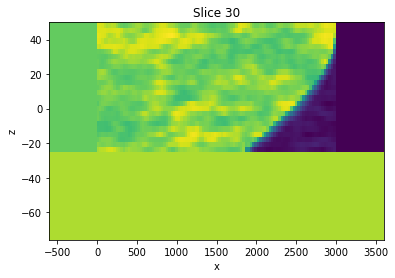

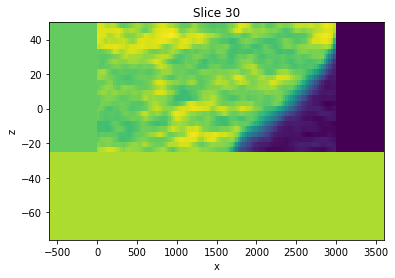

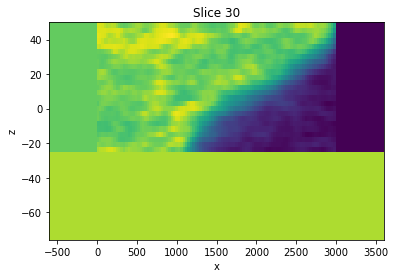

In [53]:
#Create and save mesh and resistivity grid
meshes = []
for tim,sig in zip(times,sig_mats):
    meshes.append(create_mesh(sig,export_UBC=True,name=int(tim), plotyn=True))
    
# np.savez_compressed(datadir.joinpath('res_grids.npz'),[1/sig for sig in sig_mats])